In [1]:
%matplotlib inline

import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from random import shuffle
from keras.applications import VGG16
from keras.applications import VGG19
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Activation
import sys
import h5py


In [2]:
def print_progress(count, max_count):

    pct_complete = count / max_count

    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    sys.stdout.write(msg)
    sys.stdout.flush()

In [3]:
in_dir = "./reallife_dataset/"

In [4]:

img_size = 224
img_size_touple = (img_size, img_size)
num_channels = 3
img_size_flat = img_size * img_size * num_channels
num_classes = 2
_num_files_train = 1
_images_per_file = 20
_num_images_train = _num_files_train * _images_per_file
video_exts = ".avi"

In [5]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    images = []
    vidcap = cv2.VideoCapture(in_file)
    success,image = vidcap.read()    
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
        images.append(res)
        success,image = vidcap.read()
        count += 1     
    resul = np.array(images) 
    resul = (resul / 255.).astype(np.float16)
        
    return resul

In [6]:
def label_video_names(in_dir):
    
    names = []
   
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                     
            
    c = list(zip(names,labels))
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [7]:

names, labels = label_video_names(in_dir)
print(labels)

([0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1],

In [8]:
names[12]

'fi2269_xvid..avi'

In [9]:
frames = get_frames(in_dir, names[12])

In [10]:
visible_frame = (frames*255).astype('uint8')

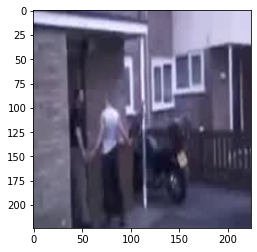

In [11]:
plt.imshow(visible_frame[3])

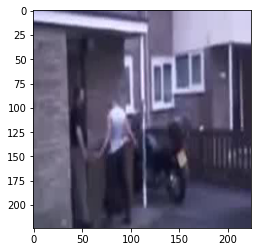

In [12]:
plt.imshow(visible_frame[15])

In [13]:
image_model = VGG16(include_top=True, weights='imagenet')

In [14]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
image_model.layers[0].output_shape[0:1]

[(None, 224, 224, 3)]

In [16]:
input_shape = image_model.layers[0].output_shape[:]

input_shape=(224,224)
print(input_shape)

(224, 224)


In [17]:

transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [18]:
def get_transfer_values(current_dir, file_name):
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    image_batch = get_frames(current_dir, file_name)
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [19]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        image_batch = np.zeros(shape=shape, dtype=np.float16)
        image_batch = get_frames(in_dir, video_name)
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        aux = np.ones([20,2])
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [20]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba.h5', 'w') as f:

        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [21]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation.h5', 'w') as f:

        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [22]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [23]:
make_files(training_set)

- Progress: 99.9%

In [24]:
make_files_test(test_set)

- Progress: 99.7%

In [25]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('prueba.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [26]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('pruebavalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [27]:
data, target = process_alldata_training()

In [28]:
data_test, target_test = process_alldata_test()

In [29]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D, MaxPooling2D,LSTM,Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard

NAME="Reallife"

tensorboard=TensorBoard(log_dir='logs/{}'.format(NAME))
model=Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(20, 2048))))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='sigmoid'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(np.array(data[0:750]), np.array(target[0:750]),epochs=200,
                    validation_data=(np.array(data[750:]), np.array(target[750:])),
                    batch_size=500,callbacks=[tensorboard])
model.save("reallife.h5")


Epoch 1/200
2/2 [==============================] - 13s 6s/step - loss: 0.2570 - accuracy: 0.4704 - val_loss: 0.2328 - val_accuracy: 0.6331
Epoch 2/200
2/2 [==============================] - 2s 1s/step - loss: 0.2385 - accuracy: 0.6142 - val_loss: 0.2302 - val_accuracy: 0.6331
Epoch 3/200
2/2 [==============================] - 2s 1s/step - loss: 0.2346 - accuracy: 0.6149 - val_loss: 0.2291 - val_accuracy: 0.6331
Epoch 4/200
2/2 [==============================] - 2s 1s/step - loss: 0.2333 - accuracy: 0.6116 - val_loss: 0.2272 - val_accuracy: 0.6331
Epoch 5/200
2/2 [==============================] - 2s 1s/step - loss: 0.2317 - accuracy: 0.6076 - val_loss: 0.2239 - val_accuracy: 0.6331
Epoch 6/200
2/2 [==============================] - 2s 1s/step - loss: 0.2287 - accuracy: 0.6096 - val_loss: 0.2203 - val_accuracy: 0.6331
Epoch 7/200
2/2 [==============================] - 2s 2s/step - loss: 0.2245 - accuracy: 0.6129 - val_loss: 0.2184 - val_accuracy: 0.6331
Epoch 8/200
2/2 [================

In [30]:
result = model.evaluate(np.array(data_test), np.array(target_test))

12/12 [==============================] - 0s 36ms/step - loss: 0.0949 - accuracy: 0.8809


In [31]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.09487171471118927
accuracy 0.880886435508728


In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


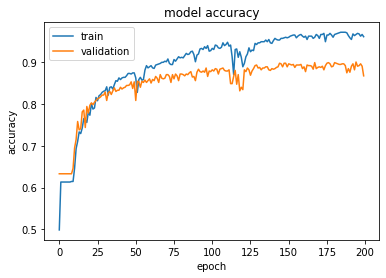

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


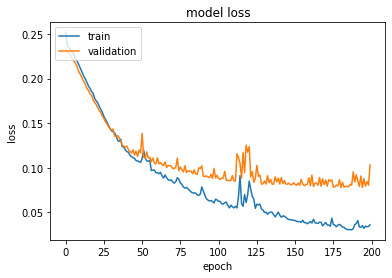

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()